## La décompression
La décompression est le procédé inverse. (dézigzaguer + huffman, déquantifier, DCT-inverse, et finalement un resize)

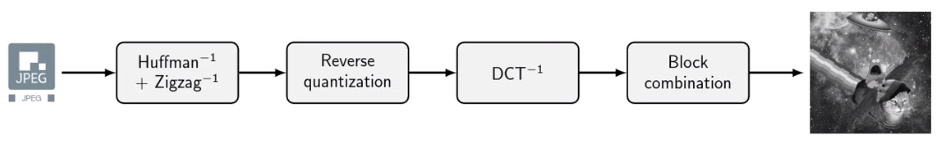

## IMPORTS

In [82]:
import os
import imageio

import numpy as np
import itertools
import math

import decimal
import unittest

import random

import matplotlib.pylab as plt

## HUFFMAN INVERSÉ

##### Functions auxiliaires pour Huffman

In [83]:
# A helper function to read one char at a time
# it takes care of the offset with a _pointer_

def read_char(b, offset):
    res = b[offset[0]]
    offset[0] += 1
    return res


In [84]:
# It adds up a string while checking if the key
# exists in _dico_

def search_in(b, offset, dico):
    search = read_char(b, offset)

    while search not in dico and len(search) < 100:
        search += read_char(b, offset)

    if search not in dico:
        print("huffman_decode_DC: Big error")
        exit(1)

    return dico[search]


In [85]:
# All required tables for huffman

DCTable = [
    ("010", 3), ("011", 4), ("100", 5), ("00", 5),
    ("101", 7), ("110", 8), ("1110", 10),
    ("11110", 12), ("111110", 14), ("1111110", 16),
    ("11111110", 18), ("111111110", 20)
]

ACTable = [
    [  # 0/0 - 0/A
        ("1010", 4),
        ("00", 3),
        ("01", 4),
        ("100", 6),
        ("1011", 8),
        ("11010", 10),
        ("111000", 12),
        ("1111000", 14),
        ("1111110110", 18),
        ("1111111110000010", 25),
        ("1111111110000011", 26),
    ],
    [  # 1/1 - 1/A
        ("0", -1),
        ("1100", 5),
        ("111001", 8),
        ("1111001", 10),
        ("111110110", 13),
        ("11111110110", 16),
        ("1111111110000100", 22),
        ("1111111110000101", 23),
        ("1111111110000110", 24),
        ("1111111110000111", 25),
        ("1111111110001000", 26),
    ],
    [  # 2/1 - 2/A
        ("0", -1),
        ("11011", 6),
        ("11111000", 10),
        ("1111110111", 13),
        ("1111111110001001", 20),
        ("1111111110001010", 21),
        ("1111111110001011", 22),
        ("1111111110001100", 23),
        ("1111111110001101", 24),
        ("1111111110001110", 25),
        ("1111111110001111", 26),
    ],
    [  # 3/1 - 3/A
        ("0", -1),
        ("111010", 7),
        ("111110111", 11),
        ("11111110111", 14),
        ("1111111110010000", 20),
        ("1111111110010001", 21),
        ("1111111110010010", 22),
        ("1111111110010011", 23),
        ("1111111110010100", 24),
        ("1111111110010101", 25),
        ("1111111110010110", 26),
    ],
    [  # 4/1 - 4/A
        ("0", -1),
        ("111011", 7),
        ("1111111000", 12),
        ("1111111110010111", 19),
        ("1111111110011000", 20),
        ("1111111110011001", 21),
        ("1111111110011010", 22),
        ("1111111110011011", 23),
        ("1111111110011100", 24),
        ("1111111110011101", 25),
        ("1111111110011110", 26),
    ],
    [  # 5/1 - 5/A
        ("0", -1),
        ("1111010", 8),
        ("1111111001", 12),
        ("1111111110011111", 19),
        ("1111111110100000", 20),
        ("1111111110100001", 21),
        ("1111111110100010", 22),
        ("1111111110100011", 23),
        ("1111111110100100", 24),
        ("1111111110100101", 25),
        ("1111111110100110", 26),
    ],
    [  # 6/1 - 6/A
        ("0", -1),
        ("1111011", 8),
        ("11111111000", 13),
        ("1111111110100111", 19),
        ("1111111110101000", 20),
        ("1111111110101001", 21),
        ("1111111110101010", 22),
        ("1111111110101011", 23),
        ("1111111110101100", 24),
        ("1111111110101101", 25),
        ("1111111110101110", 26),
    ],
    [  # 7/1 - 7/A
        ("0", -1),
        ("11111001", 9),
        ("11111111001", 13),
        ("1111111110101111", 19),
        ("1111111110110000", 20),
        ("1111111110110001", 21),
        ("1111111110110010", 22),
        ("1111111110110011", 23),
        ("1111111110110100", 24),
        ("1111111110110101", 25),
        ("1111111110110110", 26),
    ],
    [  # 8/1 - 8/A
        ("0", -1),
        ("11111010", 9),
        ("111111111000000", 17),
        ("1111111110110111", 19),
        ("1111111110111000", 20),
        ("1111111110111001", 21),
        ("1111111110111010", 22),
        ("1111111110111011", 23),
        ("1111111110111100", 24),
        ("1111111110111101", 25),
        ("1111111110111110", 26),
    ],
    [  # 9/1 - 9/A
        ("0", -1),
        ("111111000", 10),
        ("1111111110111111", 18),
        ("1111111111000000", 19),
        ("1111111111000001", 20),
        ("1111111111000010", 21),
        ("1111111111000011", 22),
        ("1111111111000100", 23),
        ("1111111111000101", 24),
        ("1111111111000110", 25),
        ("1111111111000111", 26),
    ],
    [  # A/1 - A/A
        ("0", -1),
        ("111111001", 10),
        ("1111111111001000", 18),
        ("1111111111001001", 19),
        ("1111111111001010", 20),
        ("1111111111001011", 21),
        ("1111111111001100", 22),
        ("1111111111001101", 23),
        ("1111111111001110", 24),
        ("1111111111001111", 25),
        ("1111111111010000", 26),
    ],
    [  # B/1 - B/A
        ("0", -1),
        ("111111010", 10),
        ("1111111111010001", 18),
        ("1111111111010010", 19),
        ("1111111111010011", 20),
        ("1111111111010100", 21),
        ("1111111111010101", 22),
        ("1111111111010110", 23),
        ("1111111111010111", 24),
        ("1111111111011000", 25),
        ("1111111111011001", 26),
    ],
    [  # C/1 - C/A
        ("0", -1),
        ("1111111010", 11),
        ("1111111111011010", 18),
        ("1111111111011011", 19),
        ("1111111111011100", 20),
        ("1111111111011101", 21),
        ("1111111111011110", 22),
        ("1111111111011111", 23),
        ("1111111111100000", 24),
        ("1111111111100001", 25),
        ("1111111111100010", 26),
    ],
    [  # D/1 - D/A
        ("0", -1),
        ("11111111010", 12),
        ("1111111111100011", 18),
        ("1111111111100100", 19),
        ("1111111111100101", 20),
        ("1111111111100110", 21),
        ("1111111111100111", 22),
        ("1111111111101000", 23),
        ("1111111111101001", 24),
        ("1111111111101010", 25),
        ("1111111111101011", 26),
    ],
    [  # E/1 - E/A
        ("0", -1),
        ("111111110110", 13),
        ("1111111111101100", 18),
        ("1111111111101101", 19),
        ("1111111111101110", 20),
        ("1111111111101111", 21),
        ("1111111111110000", 22),
        ("1111111111110001", 23),
        ("1111111111110010", 24),
        ("1111111111110011", 25),
        ("1111111111110100", 26),
    ],
    [  # F/0 - F/A
        ("111111110111", 12),  # F/0 => 16 zeros d'affilés
        ("1111111111110101", 17),
        ("1111111111110110", 18),
        ("1111111111110111", 19),
        ("1111111111111000", 20),
        ("1111111111111001", 21),
        ("1111111111111010", 22),
        ("1111111111111011", 23),
        ("1111111111111100", 24),
        ("1111111111111101", 25),
        ("1111111111111110", 26),
    ]
]

In [86]:
# We needed a quick way to decode data, 
# a dictionnary was simple enough for us

# We compute the inverse before making architectural
# changes to the actual table

invACTable = dict()
for i, AC in enumerate(ACTable):
    for j, e in enumerate(AC):
        res = dict()
        res["run"] = i
        res["length"] = e[1]
        res["to_read"] = e[1] - len(e[0])
        res["cat"] = j
        if (i == 0 or i == 15) and j == 0:
            invACTable[e[0]] = res
        elif j == 0:
            continue

        invACTable[e[0]] = res


invDCTable = dict()
for i, DC in enumerate(DCTable):
    res = dict()
    res["length"] = DC[1]
    res["to_read"] = DC[1] - len(DC[0])
    res["cat"] = i
    invDCTable[DC[0]] = res


DCTable = [{"basecode": int(e[0], 2),
            "length": e[1],
            "shift": e[1] - len(e[0])} for e in DCTable]


for i, elem in enumerate(ACTable):
    tmp = [{"basecode": int(e[0], 2),
            "length": e[1],
            "shift": e[1] - len(e[0])} for e in elem]
    ACTable[i] = tmp

In [87]:
# We decode huffman first, coef by coef

def huffman_number_2(s, cat):
    if len(s) == 0:
        return 0
    if len(s) == 1:
        return -1 if s == "0" else 1
    if s[0] == '0':
        return -2 ** (cat) + 1 + (int(s[1:], 2)) if s[1:] else 0
    else:
        return 2 ** (cat - 1) + (int(s[1:], 2)) if s[1:] else 0


def huffman_decode_DC(b, offset):
    table = search_in(b, offset, invDCTable)
    nb_to_read = table["to_read"]

    res = ""
    for _ in range(nb_to_read):
        res += read_char(b, offset)

    return huffman_number_2(res, table["cat"])


def huffman_decode_AC(b, offset):
    res = []
    while True:
        table = search_in(b, offset, invACTable)
        nb_to_read = table["to_read"]
        if nb_to_read == 0 and table["length"] == 4:
            return res

        res_str = ""
        for _ in range(nb_to_read):
            res_str += read_char(b, offset)

        for _ in range(table["run"]):
            res.append(0)

        if nb_to_read != 0:
            res.append(huffman_number_2(res_str, table["cat"]))
        else:
            res.append(0)

    return res



In [88]:
# We decode block of huffman encodings

def huffman_decode_block(b, offset):
    DC = huffman_decode_DC(b, offset)
    ACs = huffman_decode_AC(b, offset)
    return [DC] + ACs


def huffman_decode_generator(b, height, width):
    # Offset is always a list, so it's like pointer
    offset = [0]

    for i in range(math.ceil(height / 8)):
        for j in range(math.ceil(width / 8)):
            for _ in range(3):
                yield huffman_decode_block(b, offset)


def huffman_decode(b, height, width):
    return list(huffman_decode_generator(b, height, width))


## ZIGZAG INVERSÉ

In [89]:
def zigzag_generator(input_qtz):
    solution = [[] for i in range(8 + 8 - 1)]

    for i in range(8):
        for j in range(8):
            sum = i + j
            if (sum % 2 == 0):
                solution[sum].insert(0, input_qtz[i * 8 + j])
            else:
                solution[sum].append(input_qtz[i * 8 + j])

    return [e for l in solution for e in l]

def zigzag(quantized):
    assert len(quantized) == 64
    l = list(zigzag_generator(quantized))
    while l[-1] == 0:
        del l[-1]
    return l

In [90]:
# To unzigzag a zigzaged matrix:
unzig_matrix = zigzag(list(range(64)))


def unzigzag(m):
    res = np.zeros(64)
    for i in range(64):
        if i < len(m):
            res[unzig_matrix[i]] = m[i]

    return res


## QUANTIFICATION INVERSÉE

In [91]:
JPEG_MATRIX_QUANTIFICATION = [16, 11, 10, 16, 24, 40, 51, 61,
                              12, 12, 14, 19, 26, 58, 60, 55,
                              14, 13, 16, 24, 40, 57, 69, 56,
                              14, 17, 22, 29, 51, 87, 80, 62,
                              18, 22, 37, 56, 68, 109, 103, 77,
                              24, 35, 55, 64, 81, 104, 113, 92,
                              49, 64, 78, 87, 703, 121, 120, 101,
                              72, 92, 95, 98, 112, 100, 103, 99]

JPEG_MATRIX_QUANTIFICATION = np.array(JPEG_MATRIX_QUANTIFICATION)

In [92]:
def unquantization(dct):
    assert len(dct) == 64
    for i in range(64):
        dct[i] *= JPEG_MATRIX_QUANTIFICATION[i]

    return np.rint(dct).astype(np.int64)


## DCT INVERSÉE

In [93]:
DCT = np.zeros((8, 8))
for i, j in itertools.product(range(8), range(8)):
    if i == 0:
        DCT[i][j] = math.sqrt(2) / 2
    else:
        DCT[i][j] = math.cos(((2 * j + 1) * i * math.pi) / 16)
DCT = (1/2) * DCT


DCT_t = DCT.transpose()

In [94]:
# Using same method with matrix multiplication

def unDCT_coeffs_8x8(image):
    image = image.reshape((8, 8))
    res = np.dot(np.dot(DCT_t, image), DCT)
    return res.reshape(64).clip(0, 255)


## RECONTRUCTION DE L'IMAGE

In [98]:
# To read from file, we need to convert back
# e.g. 108 = "0110 1100" (without space)

def bytes_to_string(b):
    out = ""
    for i in b:
        for j in range(8):
            offset = 2 ** (7 - j)
            if i & offset:
                out += "1"
            else:
                out += "0"
    return out


In [99]:
# The actual decompress process

# We first get the encoded data (height, width, padded_zeros and quality)
# Then we remove the padded_zeros
# And we launch the pipeline

def decompress(filename):
    global JPEG_MATRIX_QUANTIFICATION
    out = None
    with open(filename, "rb") as f:
        out = f.read()

    height = out[0] * 256 + out[1]
    width = out[2] * 256 + out[3]
    padded_zeros = out[4]
    q = out[5]
    
    print(f"{height = }")
    print(f"{width = }")
    print(f"{padded_zeros = }")
    print(f"{q = }")
    
    JPEG_MATRIX_QUANTIFICATION = np.array([16, 11, 10, 16, 24, 40, 51, 61,
                              12, 12, 14, 19, 26, 58, 60, 55,
                              14, 13, 16, 24, 40, 57, 69, 56,
                              14, 17, 22, 29, 51, 87, 80, 62,
                              18, 22, 37, 56, 68, 109, 103, 77,
                              24, 35, 55, 64, 81, 104, 113, 92,
                              49, 64, 78, 87, 703, 121, 120, 101,
                              72, 92, 95, 98, 112, 100, 103, 99])
    
    if q != 50:
        if q > 50:
            alpha = 200 - 2 * q
        else:
            alpha = 5000 / q
        JPEG_MATRIX_QUANTIFICATION = (
            (alpha * JPEG_MATRIX_QUANTIFICATION) + 50) / 100

    out = bytes_to_string(out[6:])
    if padded_zeros > 0:
        out = out[:-padded_zeros]

    pad_height = (8 - (height % 8)) % 8
    pad_width = (8 - (width % 8)) % 8

    virtual_height = height + pad_height
    virtual_width = width + pad_width

    image_out = np.zeros((virtual_height, virtual_width, 3), dtype=np.uint8)

    block_width = virtual_width // 8

    blocks = huffman_decode(out, height, width)

    for i in range(0, len(blocks), 3):
        for j in [0, 1, 2]:
            b = blocks[i + j]
            block_y = (i // 3) // block_width
            block_x = (i // 3) % block_width

            unzzg = unzigzag(b)
            unqtz = unquantization(unzzg)
            undct = unDCT_coeffs_8x8(unqtz)

            reshp = undct.reshape((8, 8))
            image_out[block_y * 8:block_y * 8 + 8, block_x * 8:block_x * 8+8, j] = \
                reshp

    imageio.imwrite("decoded_image.bmp", image_out[:height, :width])


## La fonction MAIN

In [100]:
def main(filename, compare_to):
    decompress(filename)
    image = imageio.imread("decoded_image.bmp")
    imageCompareTo = imageio.imread(compare_to)

    plt.imshow(image), plt.axis('off'), plt.show()
    print(image.shape)

    mse = ((image - imageCompareTo)**2).mean(axis=None)
    print(f"{ mse = }")
    rmse = math.sqrt(mse)
    print(f"{rmse = }")

height = 567
width = 567
padded_zeros = 7
q = 5


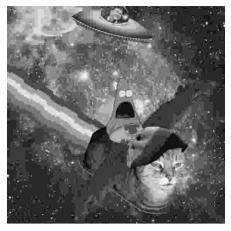

(567, 567, 3)
 mse = 66.33779693861999
rmse = 8.144801835442038


In [101]:
main("out5.ourjpg", "assets/nyancat-patrick.png")

## TESTS

height = 567
width = 567
padded_zeros = 5
q = 25


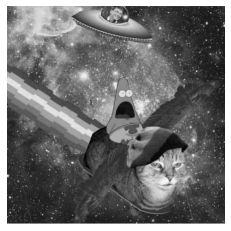

(567, 567, 3)
 mse = 32.062114100326916
rmse = 5.662341750576957


In [102]:
main("out25.ourjpg", "assets/nyancat-patrick.png")


height = 567
width = 567
padded_zeros = 0
q = 50


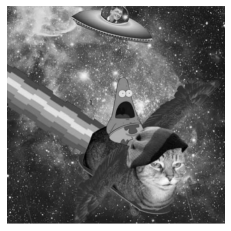

(567, 567, 3)
 mse = 19.586331103085953
rmse = 4.425644710444565


In [103]:
main("out50.ourjpg", "assets/nyancat-patrick.png")

height = 567
width = 567
padded_zeros = 0
q = 75


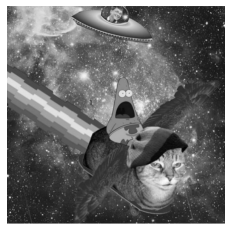

(567, 567, 3)
 mse = 11.400921960004853
rmse = 3.3765251309600606


In [104]:
main("out75.ourjpg", "assets/nyancat-patrick.png")

height = 567
width = 567
padded_zeros = 0
q = 95


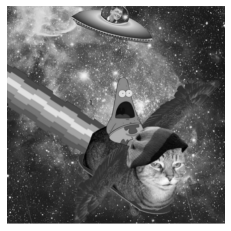

(567, 567, 3)
 mse = 2.16449085349732
rmse = 1.471220871758323


In [105]:
main("out95.ourjpg", "assets/nyancat-patrick.png")
